In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from rnn_tutorial import vrnn, generate_input_target, plot_integration, plot_weights

In [2]:
# check for GPU, use CPU if GPU not available
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [3]:
# rnn parameters
input_size = 1 # must be 1 for integration example
hidden_size = 10 # feel free to change
output_size = 1 # must be 1 for integration example

# instantiate model and send it to device
model = vrnn(input_size, hidden_size, output_size)
model.to(device)

vrnn(
  (rnn): RNN(1, 10)
  (out): Linear(in_features=10, out_features=1, bias=True)
)

In [4]:
# generate inputs x and integrated targets t
seq_len = 20 # length of input sequence (aka # of timesteps)
n_seq = 10 # number of i/o sequences to generate

x, t = generate_input_target(input_size, seq_len, n_seq)

# we need to convert numpy arrays to torch tensors
x = torch.Tensor(x)
t = torch.Tensor(t)

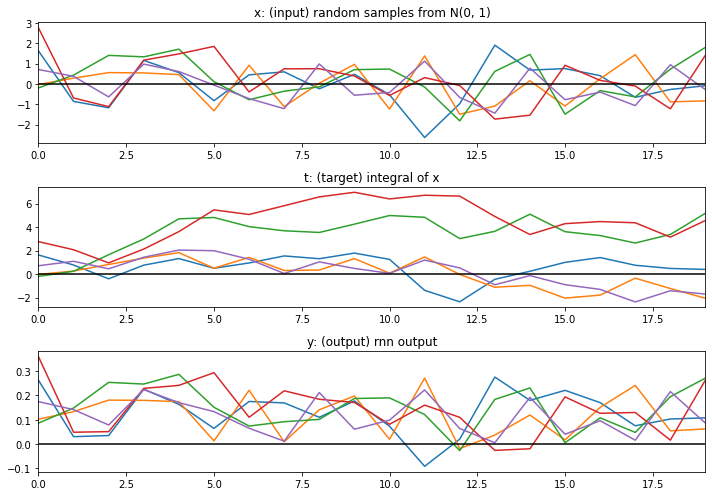

In [5]:
# take a look at rnn output pre-training
y, h = model.forward(x)
plot_integration(x, t, y)

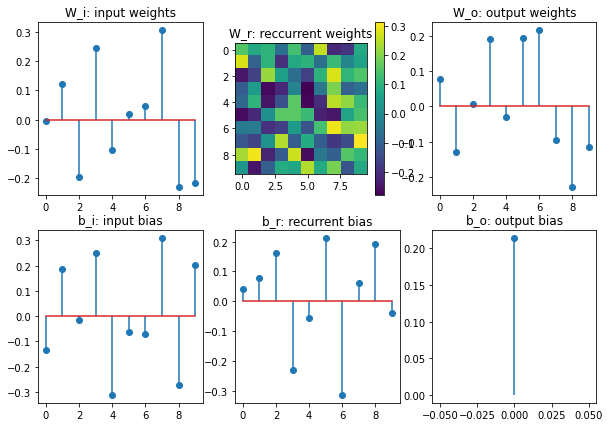

In [7]:
# take a look at the weights pre-training
plot_weights(model)

In [8]:
# training parameters
n_epochs = 500
lr = 0.01 # learning rate

# define loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Epoch: 20/500............. Loss: 5.6375
Epoch: 40/500............. Loss: 4.4163
Epoch: 60/500............. Loss: 3.1466
Epoch: 80/500............. Loss: 1.6225
Epoch: 100/500............. Loss: 0.7108
Epoch: 120/500............. Loss: 0.2509
Epoch: 140/500............. Loss: 0.1584
Epoch: 160/500............. Loss: 0.1183
Epoch: 180/500............. Loss: 0.0925
Epoch: 200/500............. Loss: 0.0744
Epoch: 220/500............. Loss: 0.0612
Epoch: 240/500............. Loss: 0.0515
Epoch: 260/500............. Loss: 0.0441
Epoch: 280/500............. Loss: 0.2365
Epoch: 300/500............. Loss: 0.0981
Epoch: 320/500............. Loss: 0.0383
Epoch: 340/500............. Loss: 0.0303
Epoch: 360/500............. Loss: 0.0265
Epoch: 380/500............. Loss: 0.0234
Epoch: 400/500............. Loss: 0.0209
Epoch: 420/500............. Loss: 0.0595
Epoch: 440/500............. Loss: 0.0235
Epoch: 460/500............. Loss: 0.0208
Epoch: 480/500............. Loss: 0.0159
Epoch: 500/500......

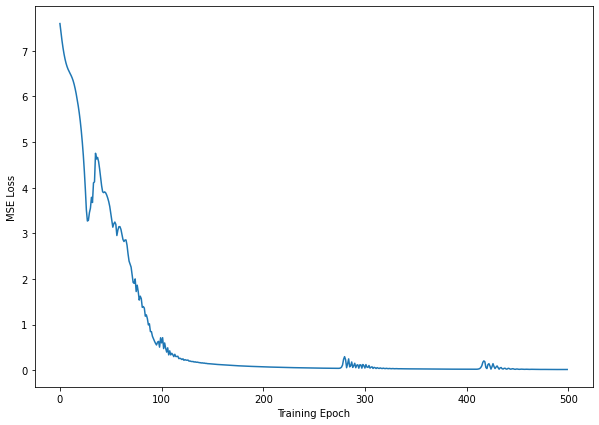

In [9]:
# training loop
loss_all = []

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # reset gradients 
    x.to(device) # mainly necessary for GPU
    y, h = model.forward(x)
    loss = criterion(y, t)
    loss.backward() # this line does all backprop + grad calculation!
    optimizer.step() # updates weights
    
    if epoch%20 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))
    
    # store loss
    loss_all.append(loss.detach().numpy())

# plot loss
plt.figure(figsize=(10,7))
plt.plot(loss_all)
plt.xlabel("Training Epoch")
plt.ylabel("MSE Loss")
plt.show()

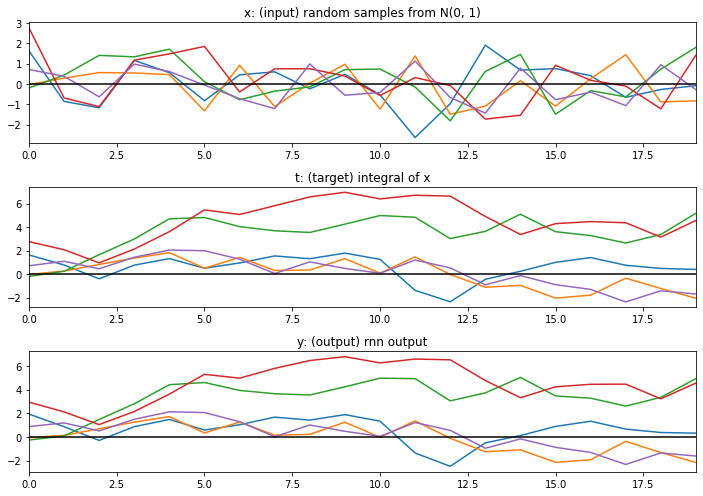

In [10]:
# plot performance on the training set
y, h = model.forward(x)
plot_integration(x, t, y)

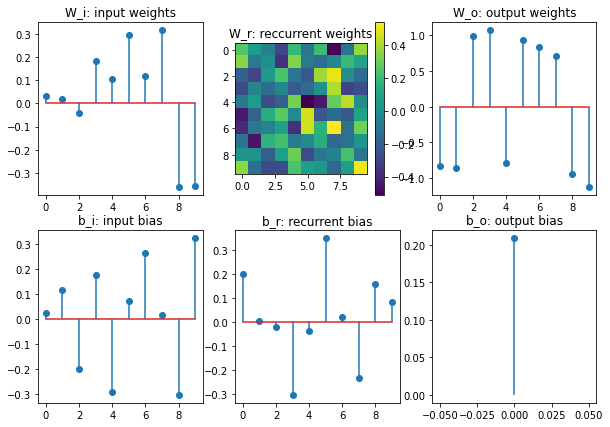

In [11]:
# plot trained weights
plot_weights(model)

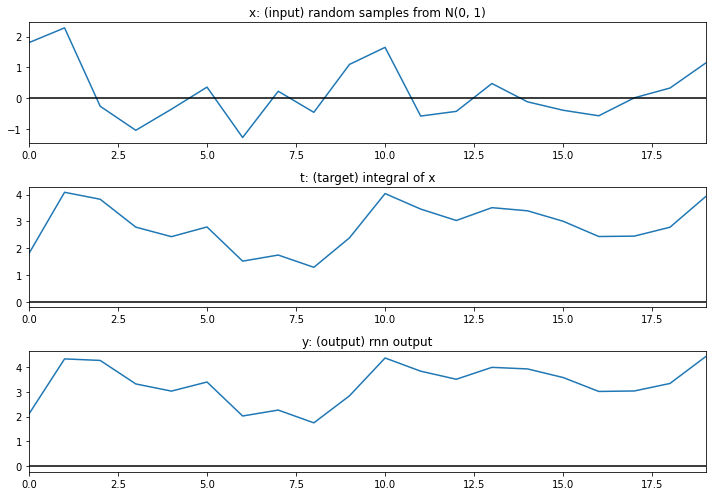

Test MSE loss: 0.238208


In [26]:
# test with a new random input
x_test, t_test = generate_input_target(input_size, seq_len=20, n_seq=1)
x_test = torch.Tensor(x_test)
t_test = torch.Tensor(t_test)

y_test, h = model.forward(x_test)
plot_integration(x_test, t_test, y_test)

loss_test = float(criterion(y_test, t_test))
print("Test MSE loss: %f" % loss_test)

## Digging deeper

There are many things worth tinkering with using this toy model.
- Generalizability: You might want to generate an entire test set to evaluate training vs test performance. Maybe more interesting: can the RNN generalize to a longer `seq_len` than we used for training?
- Number of hidden units: Play around with different values for `hidden_size`.. can the network perform integration with 1 unit?
- Sequence length: The longer the input sequence, the further we have to backpropagate errors. How does `seq_len` impact training/performance? Do errors accumulate over time?
- Number of training examples: How does `n_seq` impact training? Generalizability?
- Training hyperparams: Changing `n_epochs` will change the number of times we run backprop on the dataset, and `lr` controls the learning rate.
- Hidden unit activation: You can access the hidden state across all timesteps using `model.h_all`.
